In [6]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # For saving models and preprocessors
import os
from datetime import datetime # For feature engineering

# Scikit-learn imports
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder # LabelEncoder for target
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Model Algorithm (Example: XGBoost Classifier)
import xgboost as xgb

# --- Configuration ---
MODEL_NAME_PREFIX = "gate" # Used for naming saved files
TARGET_COLUMN = "Gate" # This is our categorical target
DATA_PATH = '../data/TAS_Airport_Data_2024_cleaned_exploratory.csv'
MODELS_DIR = '../models/'
MODELS_META_DIR = '../models_meta/'

# Create directories if they don't exist
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(MODELS_META_DIR, exist_ok=True)


# CRISP-DM Phase: Data Understanding (Brief Recap) & Preparation

In [2]:



# 1. Load Data
df_raw = pd.read_csv(DATA_PATH)
df = df_raw.copy()
df.columns = df.columns.str.strip()

# 2. Define Target Variable (y) and Initial Features (X_initial)
if TARGET_COLUMN not in df.columns:
    raise ValueError(f"Target column '{TARGET_COLUMN}' not found in DataFrame.")

# Drop rows where target is NaN (cannot train or evaluate on these)
df.dropna(subset=[TARGET_COLUMN], inplace=True)
# Ensure Gate is treated as a string/object if it contains mixed types like "A1", "10"
df[TARGET_COLUMN] = df[TARGET_COLUMN].astype(str)
print(f"Shape after dropping NaNs in target '{TARGET_COLUMN}': {df.shape}")
print(f"Unique values in '{TARGET_COLUMN}': {df[TARGET_COLUMN].nunique()}")
print(df[TARGET_COLUMN].value_counts().head())


# Label Encode the Target Variable 'Gate'
# XGBoost can sometimes handle string labels if use_label_encoder=False (for binary)
# or if it internally uses something similar for multi-class.
# However, for clarity and broader compatibility, explicit label encoding is good practice for multiclass.
le = LabelEncoder()
y_encoded = le.fit_transform(df[TARGET_COLUMN])
num_classes = len(le.classes_)
print(f"Target variable '{TARGET_COLUMN}' label encoded into {num_classes} classes.")
# Save the label encoder to be able to inverse_transform predictions later
label_encoder_filename = f"label_encoder_{MODEL_NAME_PREFIX}.pkl"
label_encoder_path = os.path.join(MODELS_META_DIR, label_encoder_filename)
joblib.dump(le, label_encoder_path)
print(f"Label encoder saved to: {label_encoder_path}")

# Assign y after encoding
y = pd.Series(y_encoded, index=df.index) # Use original df index for y

# Drop target, ID, and other potential leakages/outcomes
X_initial = df.drop(columns=[TARGET_COLUMN, 'FlightID', 'ReasonForDelay', 
                             'DepartureDelay', 'ArrivalDelay', 'OnTimePerformance']) # These are outcomes, not inputs for gate assignment

# 3. Feature Engineering
print("\n--- Feature Engineering ---")

# Datetime features from 'ScheduledArrivalTime' (Key for gate assignment)
if 'ScheduledArrivalTime' in X_initial.columns:
    X_initial['ScheduledArrivalTime'] = pd.to_datetime(X_initial['ScheduledArrivalTime'], errors='coerce')
    
    X_initial['Arrival_Hour'] = X_initial['ScheduledArrivalTime'].dt.hour
    X_initial['Arrival_Minute_Bin'] = (X_initial['ScheduledArrivalTime'].dt.minute // 15) # Bin minutes (0, 15, 30, 45)
    X_initial['Arrival_DayOfWeek'] = X_initial['ScheduledArrivalTime'].dt.dayofweek
    X_initial['Arrival_Month'] = X_initial['ScheduledArrivalTime'].dt.month
    X_initial['Arrival_Is_Weekend'] = X_initial['ScheduledArrivalTime'].dt.dayofweek.isin([5, 6]).astype(int)
    
    X_initial = X_initial.drop(columns=['ScheduledArrivalTime'])
    print("Engineered datetime features from ScheduledArrivalTime.")
else:
    print("Warning: 'ScheduledArrivalTime' column not found for feature engineering.")

# Scheduled Departure Time (from this gate) might also be relevant for how long the gate is occupied
if 'ScheduledTime' in X_initial.columns: # Assuming 'ScheduledTime' is departure time for this flight
    X_initial['ScheduledTime'] = pd.to_datetime(X_initial['ScheduledTime'], errors='coerce')
    X_initial['Departure_Hour_From_Gate'] = X_initial['ScheduledTime'].dt.hour # Renaming
    # Potentially calculate planned ground time if both arrival and departure are for this airport turn
    X_initial = X_initial.drop(columns=['ScheduledTime'])
    print("Engineered datetime features from ScheduledTime (Departure from this gate).")


# Align X and y after potential drops from datetime parsing
X_initial = X_initial.loc[y.index] # Align X with y's current index (after label encoding)
print(f"Shape of X_initial after feature engineering: {X_initial.shape}")
print(f"Shape of y after aligning: {y.shape}")


# 4. Identify Feature Types for Preprocessing
numerical_features = X_initial.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_initial.select_dtypes(include=['object', 'category']).columns.tolist()

# Ensure 'AircraftTurnaroundTime' (if used), 'Passengers', 'FlightDuration' are numerical
# Example: If 'Passengers' was object, convert it
# if 'Passengers' in X_initial.columns and 'Passengers' not in numerical_features:
#     X_initial['Passengers'] = pd.to_numeric(X_initial['Passengers'], errors='coerce')
#     if 'Passengers' not in numerical_features: numerical_features.append('Passengers')

# Key Categorical Features for Gate Assignment:
# 'Airline', 'AircraftType', 'OriginAirport', 'ArrivalAirport' (current airport), 'GateType' (if it's a *requested* type)
# 'WeatherCondition' might influence gate availability or preference.

print(f"\nIdentified Numerical Features: {numerical_features}")
print(f"Identified Categorical Features: {categorical_features}")

# 5. Split Data into Training and Test sets
# Stratify by y for classification if class imbalance is a concern
X_train, X_test, y_train, y_test = train_test_split(X_initial, y, test_size=0.2, random_state=42, stratify=y if num_classes > 1 else None)
print(f"\nTraining set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test set shape: X_test={X_test.shape}, y_test={y_test.shape}")


# 6. Create Preprocessing Pipelines
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

active_numerical_features = [col for col in numerical_features if col in X_train.columns]
active_categorical_features = [col for col in categorical_features if col in X_train.columns]

preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, active_numerical_features),
    ('cat', categorical_pipeline, active_categorical_features)
], remainder='drop')




Shape after dropping NaNs in target 'Gate': (32940, 32)
Unique values in 'Gate': 60
Gate
A11    619
A12    601
A19    592
C14    586
B1     584
Name: count, dtype: int64
Target variable 'Gate' label encoded into 60 classes.
Label encoder saved to: ../models_meta/label_encoder_gate.pkl

--- Feature Engineering ---
Engineered datetime features from ScheduledArrivalTime.
Engineered datetime features from ScheduledTime (Departure from this gate).
Shape of X_initial after feature engineering: (32940, 30)
Shape of y after aligning: (32940,)

Identified Numerical Features: ['FlightDuration', 'BaggageHandlers', 'GroundCrew', 'FuelTrucks', 'CleaningCrew', 'Passengers', 'SecurityChecks', 'RunwayDelay', 'PreviousFlightDelay', 'AircraftTurnaroundTime', 'CheckInQueueTime', 'SecurityWaitTime', 'BaggageClaimBelts', 'CustomsOfficers', 'ImmigrationOfficers', 'Arrival_Hour', 'Arrival_Minute_Bin', 'Arrival_DayOfWeek', 'Arrival_Month', 'Arrival_Is_Weekend', 'Departure_Hour_From_Gate']
Identified Categoric

#  CRISP-DM Phase: Modeling

In [3]:


# 7. Fit the Preprocessor on the Training Data
print("\n--- Fitting Preprocessor ---")
X_train_processed_np = preprocessor.fit_transform(X_train)
feature_names_processed = list(preprocessor.get_feature_names_out())
X_train_processed = pd.DataFrame(X_train_processed_np, columns=feature_names_processed, index=X_train.index)
print(f"Shape of X_train_processed: {X_train_processed.shape}")

# Transform the Test Data
X_test_processed_np = preprocessor.transform(X_test)
X_test_processed = pd.DataFrame(X_test_processed_np, columns=feature_names_processed, index=X_test.index)
print(f"Shape of X_test_processed: {X_test_processed.shape}")


# 8. Define and Train the Model (XGBoost Classifier)
print("\n--- Model Training ---")
xgb_clf_gate = xgb.XGBClassifier(
    objective='multi:softmax',   # For multiclass classification
    num_class=num_classes,       # Number of unique gates
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False      # We've already label encoded y
)

# Optional: Hyperparameter Tuning
# param_grid_clf = { ... }
# grid_search_clf = GridSearchCV(estimator=xgb_clf_gate, param_grid=param_grid_clf, cv=KFold(n_splits=3, shuffle=True, random_state=42), scoring='accuracy', n_jobs=-1, verbose=1)
# grid_search_clf.fit(X_train_processed, y_train) # y_train is already label encoded
# print(f"Best parameters found: {grid_search_clf.best_params_}")
# xgb_clf_gate = grid_search_clf.best_estimator_

xgb_clf_gate.fit(X_train_processed, y_train) # y_train is label encoded
print("Model training complete.")





--- Fitting Preprocessor ---
Shape of X_train_processed: (26352, 60)
Shape of X_test_processed: (6588, 60)

--- Model Training ---


/Users/sardorkhalillaev/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:10:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model training complete.


# CRISP-DM Phase: Evaluation


--- Model Evaluation ---

--- Training Set Metrics (Gate Assignment) ---
Accuracy: 0.4138
Classification Report (Training):
              precision    recall  f1-score   support

          A1       0.43      0.45      0.44       429
         A10       0.48      0.35      0.41       432
         A11       0.37      0.45      0.41       495
         A12       0.54      0.43      0.48       481
         A13       0.49      0.42      0.45       428
         A14       0.34      0.40      0.36       433
         A15       0.44      0.40      0.42       410
         A16       0.37      0.41      0.39       452
         A17       0.35      0.44      0.39       459
         A18       0.48      0.42      0.45       436
         A19       0.46      0.40      0.43       474
          A2       0.43      0.47      0.45       426
         A20       0.43      0.44      0.44       445
          A3       0.46      0.41      0.44       453
          A4       0.39      0.43      0.41       413
          

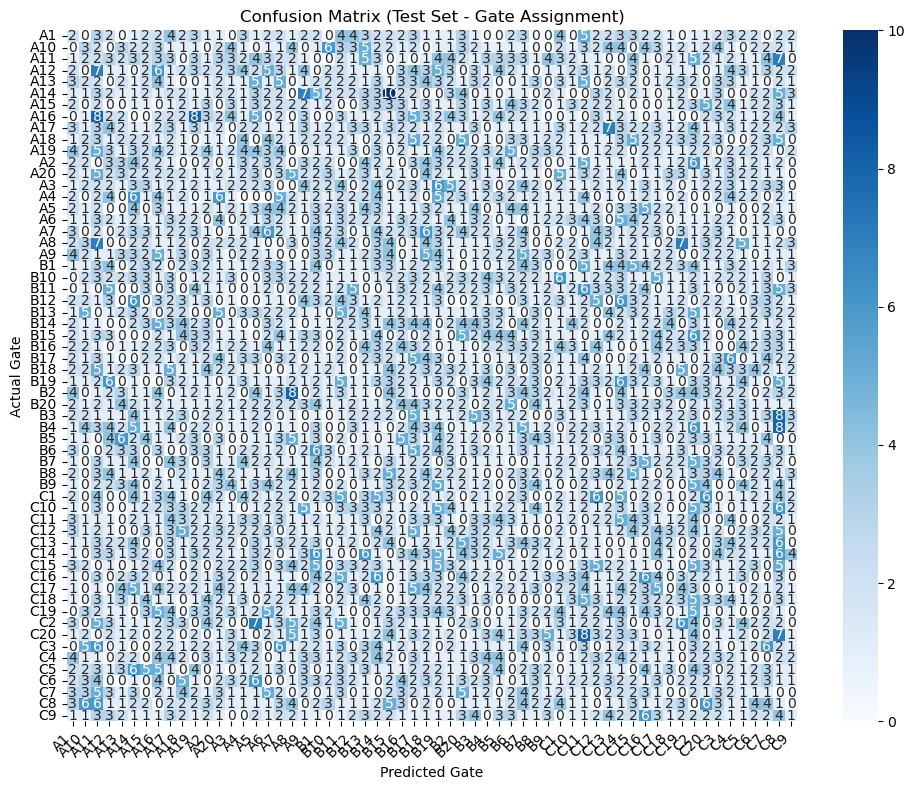

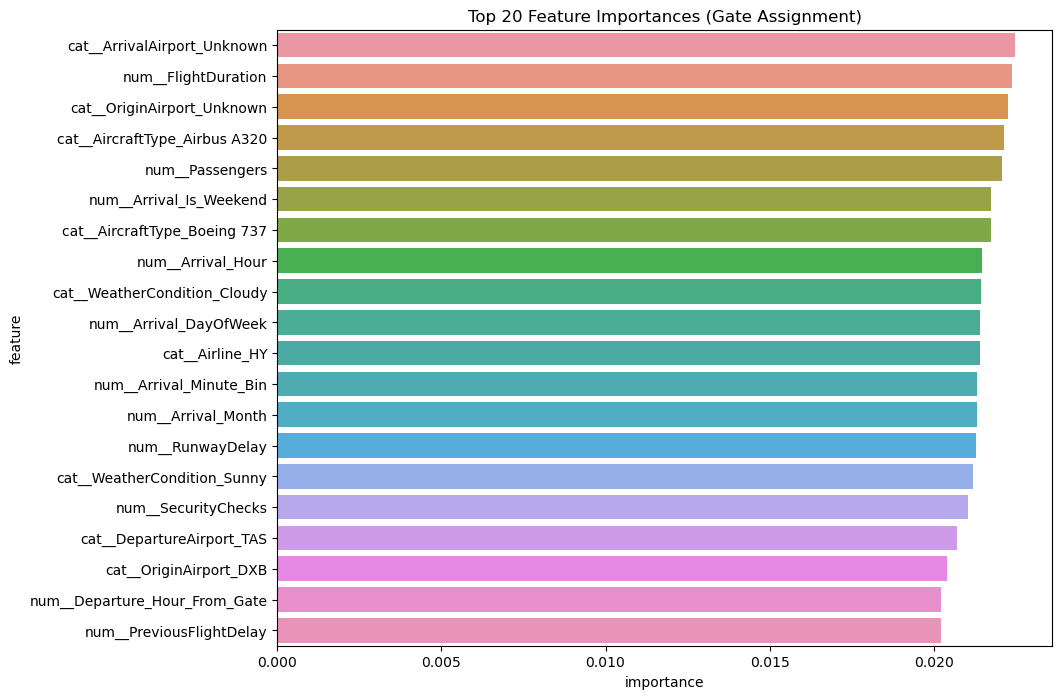

In [4]:

print("\n--- Model Evaluation ---")
y_pred_train_encoded = xgb_clf_gate.predict(X_train_processed)
y_pred_test_encoded = xgb_clf_gate.predict(X_test_processed)

# Inverse transform to get original gate labels for reporting
y_pred_train_labels = le.inverse_transform(y_pred_train_encoded)
y_pred_test_labels = le.inverse_transform(y_pred_test_encoded)
y_train_labels = le.inverse_transform(y_train) # y_train is pd.Series of encoded labels
y_test_labels = le.inverse_transform(y_test)   # y_test is pd.Series of encoded labels


print("\n--- Training Set Metrics (Gate Assignment) ---")
print(f"Accuracy: {accuracy_score(y_train_labels, y_pred_train_labels):.4f}")
print("Classification Report (Training):")
print(classification_report(y_train_labels, y_pred_train_labels, zero_division=0)) # Added zero_division

print("\n--- Test Set Metrics (Gate Assignment) ---")
print(f"Accuracy: {accuracy_score(y_test_labels, y_pred_test_labels):.4f}")
print("Classification Report (Test):")
print(classification_report(y_test_labels, y_pred_test_labels, zero_division=0)) # Added zero_division

# Confusion Matrix (Test Set)
plt.figure(figsize=(10, 8) if num_classes > 5 else (6,4)) # Adjust size based on num_classes
cm = confusion_matrix(y_test_labels, y_pred_test_labels, labels=le.classes_) # Use all original class labels
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix (Test Set - Gate Assignment)')
plt.xlabel('Predicted Gate')
plt.ylabel('Actual Gate')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Feature Importance
if hasattr(xgb_clf_gate, 'feature_importances_'):
    importances_gate = xgb_clf_gate.feature_importances_
    feature_importance_df_gate = pd.DataFrame({'feature': feature_names_processed, 'importance': importances_gate})
    feature_importance_df_gate = feature_importance_df_gate.sort_values(by='importance', ascending=False).head(20)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance_df_gate)
    plt.title('Top 20 Feature Importances (Gate Assignment)')
    plt.show()




#  CRISP-DM Phase: Deployment (Saving Artifacts)

In [5]:

print("\n--- Saving Artifacts ---")

# 1. Save the Preprocessor
preprocessor_filename_gate = f"preprocessor_{MODEL_NAME_PREFIX}.pkl"
preprocessor_path_gate = os.path.join(MODELS_META_DIR, preprocessor_filename_gate)
joblib.dump(preprocessor, preprocessor_path_gate)
print(f"Preprocessor saved to: {preprocessor_path_gate}")

# 2. Save the list of Processed Feature Names
feature_names_filename_gate = f"feature_names_{MODEL_NAME_PREFIX}.pkl"
feature_names_path_gate = os.path.join(MODELS_META_DIR, feature_names_filename_gate)
joblib.dump(feature_names_processed, feature_names_path_gate)
print(f"Feature names saved to: {feature_names_path_gate}")

# 3. Save the Trained Model (gate_classifier.pkl)
final_model_name_for_dashboard_gate = "gate_classifier.pkl"
model_path_gate = os.path.join(MODELS_DIR, final_model_name_for_dashboard_gate)
joblib.dump(xgb_clf_gate, model_path_gate)
print(f"Trained model saved to: {model_path_gate}")

# Note: LabelEncoder was already saved earlier.

print("\n--- Gate Assignment Modeling Notebook Complete ---")


--- Saving Artifacts ---
Preprocessor saved to: ../models_meta/preprocessor_gate.pkl
Feature names saved to: ../models_meta/feature_names_gate.pkl
Trained model saved to: ../models/gate_classifier.pkl

--- Gate Assignment Modeling Notebook Complete ---
